# 机器学习（入门）探索数据集

## 研究项目：《泰坦尼克号》生还探索

### 1、序
       1912年的一天，当时世界上体积最庞大、内部设施最豪华的客运轮船，有“永不沉没”美誉的泰坦尼克号，在她的处女航中撞冰山沉入大西洋底3700米处，船上1500多人丧生。一百多年后，人们对这一场旷世海难依然充满好奇，从电影作品到考古探索，越来越多的故事与猜想。那么，这艘在上世纪初无与伦比的豪华巨轮，怎么说翻就翻了？在翻船前，除了杰克与露丝的爱情，泰坦尼克号还经历了什么？
       那么到底是什么影响了乘客的生还，透过生还数据，我们能得到什么样的结果？接下来，我会通过数据分析告诉你哪些特征会影响生存率。
### 2、数据集来源
       著名的数据分析竞赛网站Kaggle上，举行了很多数据分析比赛，其中比较著名的就有 泰坦尼克号乘客生还预测 。
       Kaggle提供的数据集中，包括泰坦尼克号上 2224 名乘客和船员中 891 名的人口学数据和乘客基本信息。
### 3、数据字典解释
|属性	       |定义	             |值说明|
|:-|:---|:---|
|**PassengerId**|乘客编号            |
|**Survived**	|存活情况            |1-存活，0-死亡|
|**Pclass**	    |舱位等级	     |1-上层，2-中间层，3-底层|
|**Name**	    |乘客姓名	|
|**Sex**	    |性别	|
|**Age**	    |年龄	|
|**SibSp**	    |同乘的兄弟姐妹/配偶数 |
|**Parch**	    |同乘的父母/小孩数 |
|**Ticket**	    |船票编号	|
|**Fare**	    |船票价格	|
|**Cabin**	    |客舱号	|
|**Embarked**	|登船港口 |C：Cherbourg（瑟堡），Q：Queenstown（皇后镇），S：Southampton（南安普顿）|

## Question Phase 提出问题

- 探索舱室等级对存活率的影响
- 探索性别对存活率的影响
- 探索年龄对存活率的影响
- 探索乘客间是兄弟姐妹/配偶关系的对存活率的影响
- 探索乘客间是父母/小孩关系的对存活率的影响
- 探索票价对存活率的影响
- 探索舱室等级与性别的综合因素对存活率的影响

## Wrangling Phase 数据采集与数据清理

- 导入需要的资源库

In [544]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- 提供漂亮的可视化工具

In [545]:
%matplotlib inline

- 采集数据

In [546]:
# 导入'titanic-data.csv'数据
titanic_df = pd.read_csv("./titanic-data.csv")
# 显示样本数据的前五条信息
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


从泰坦尼克号的数据样本中，我们可以看到存在<font color=#DC143C>NAN</font>的数据（Age、Cabin、Embarked），因此为了使将要分析的变量保持一致的数据量，我们需要进行数据清洗，生成一个新的数据集，再对新的数据集进行分析探索。

- 清理数据

In [547]:
# 过滤分析过程中缺失的数据
titanic_df.dropna(subset = ['Age'], inplace = True)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    714 non-null int64
Survived       714 non-null int64
Pclass         714 non-null int64
Name           714 non-null object
Sex            714 non-null object
Age            714 non-null float64
SibSp          714 non-null int64
Parch          714 non-null int64
Ticket         714 non-null object
Fare           714 non-null float64
Cabin          185 non-null object
Embarked       712 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 72.5+ KB


## Expore Phase 数据探索 提炼问题

In [548]:
# 定义常量
SURVIVED = 'Survived'
DENSITY = 'Density'
SHOW_KIND_BAR = 'bar'
SHOW_KIND_PIE = 'pie'
HEADER_SURVIVED = 'survived'
HEADER_TOTAL = 'total'
HEADER_RATE = 'rate'

In [549]:
def print_result(title, grouped_survied_factors, grouped_each_factor_counts, survived_rate):
    """
    数据集横向合并后输出
    title：feature title
    grouped_survied_factors：存活数
    grouped_each_factor_counts：总数
    survived_rate：成活率
    """
    print('Profile feature \"'+ title + '\" survival rate')
    print('-------------------------------------------')
    # 横向拼接并输
    result = pd.concat([grouped_survied_factors, grouped_each_factor_counts, survived_rate], axis = 1)
    result.columns = [HEADER_SURVIVED, HEADER_TOTAL, HEADER_RATE]
    print(result)

In [550]:
def prediction_with_one_factor(survived, factor, title, xlabel, ylabel):
    """
    基于单个特征因素的预测
    survived：存活
    factor：特征
    title：图形标题
    xlabel：x轴标签
    ylabel：y轴标签
    """
    df_grouped = titanic_df[[survived, factor]].groupby(factor)
    # 统计每组生存者的总数
    grouped_survied_factors = df_grouped.sum()
    # 统计分组总有人数
    grouped_each_factor_counts = df_grouped.count()
    # 计算存活率
    survived_rate = grouped_survied_factors / grouped_each_factor_counts
    
    # 横向拼接并输出
    print_result(factor, grouped_survied_factors, grouped_each_factor_counts, survived_rate)
    
    # 绘制直方图
    survived_rate.plot(kind = SHOW_KIND_BAR)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.show()

In [551]:
def prediction_with_interval_factor(survived, factor, factor_group, bins, blabels, title, xlabel, ylabel):
    """
    基于区间因素的预测
    survived：存活
    factor：特征
    factor_group：特征分组的组名
    bins：分组区间
    blabels：分组区间标签
    title：图形标题
    xlabel：x轴标签
    ylabel：y轴标签
    """
    # 根据给定的区间进行分组
    titanic_df[factor_group] = pd.cut(titanic_df[factor], bins, labels = blabels)

    factor_df = pd.concat([titanic_df[survived], titanic_df[factor_group]], axis = 1)

    df_grouped = factor_df.groupby(factor_group)
    # 统计每组生存者的总数
    grouped_survied_factors = df_grouped.sum()
    # 统计分组总有人数
    grouped_each_factor_counts = df_grouped.count()

    # 计算存活率
    survived_rate = grouped_survied_factors / grouped_each_factor_counts

    # 横向拼接并输出
    print_result(factor, grouped_survied_factors, grouped_each_factor_counts, survived_rate)
    
    # 绘制直方图与饼图
    survived_rate.plot(kind = SHOW_KIND_BAR)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    survived_rate.plot(kind = SHOW_KIND_PIE, subplots = True)
    plt.ylabel('')
    
    plt.show()

In [552]:
def prediction_with_double_factor(survived, factor1, factor2, title, xlabel, ylabel):
    """
    基于双重因素的预测
    survived：存活
    factor1：特征1
    factor2：特征2
    title：图形标题
    xlabel：x轴标签
    ylabel：y轴标签
    """
    series_grouped_factor = titanic_df.groupby([factor1, factor2])[survived]
    
    grouped_survied_factors = series_grouped_factor.sum()
    grouped_each_factor_counts = series_grouped_factor.count()

    survived_rate = grouped_survied_factors / grouped_each_factor_counts

    # 横向拼接并输出
    print_result(factor1 + ' + ' + factor2, grouped_survied_factors, grouped_each_factor_counts, survived_rate)
    
    # 绘制直方图
    survived_rate.unstack().plot(kind = SHOW_KIND_BAR)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.show()

### 1、探索舱室等级对存活率的影响

Profile feature "Pclass" survival rate
-------------------------------------------
        survived  total      rate
Pclass                           
1            122    186  0.655914
2             83    173  0.479769
3             85    355  0.239437


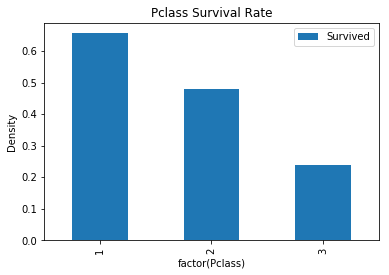

In [553]:
prediction_with_one_factor(SURVIVED, 'Pclass', 'Pclass Survival Rate', 'factor(Pclass)', DENSITY)

- 图形解读：x轴代表舱位等级，y轴代表存活率系数
- 数据解读：一级舱存活率：65.59%，二级舱存活率：47.97%，三级舱存活率：23.94%

### 2、探索性别对存活率的影响

Profile feature "Sex" survival rate
-------------------------------------------
        survived  total      rate
Sex                              
female       197    261  0.754789
male          93    453  0.205298


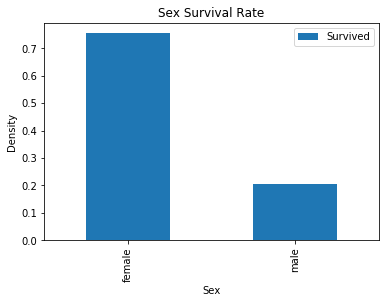

In [554]:
prediction_with_one_factor(SURVIVED, 'Sex', 'Sex Survival Rate', 'Sex', DENSITY)

- 图形解读：x轴代表性别 female（女士）、male（男士），y轴代表存活率系数
- 数据解读：女士存活率：75.47%，男士存活率：20.52%

### 3、探索年龄对存活率的影响

Profile feature "Age" survival rate
-------------------------------------------
          survived  total      rate
AgeLevel                           
child           45     77  0.584416
young          162    420  0.385714
midlife         78    195  0.400000
aged             5     22  0.227273


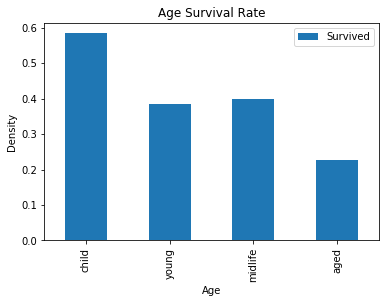

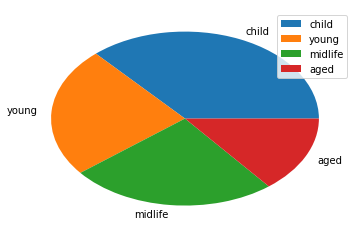

In [555]:
"""
child：少年（0-14）
young：青年（15-35）
midlife：中年（36-60）
aged：老年（61-90）
"""
bins = [0, 14, 35, 60, 90]

labels = ['child', 'young', 'midlife', 'aged']
prediction_with_interval_factor(SURVIVED, 'Age', 'AgeLevel', bins, labels, 'Age Survival Rate', 'Age', DENSITY)

- 图形解读：柱状图x轴代表各年龄段，child（少年）、young（青年）、midlife（中年）、aged（老年），y轴代表存活率系数
- 数据解读：child存活率：58.44%，young存活率：38.57%，midlife存活率：40%，aged存活率：22.72%

### 4、探索乘客间是兄弟姐妹/配偶关系的对存活率的影响

Profile feature "SibSp" survival rate
-------------------------------------------
       survived  total      rate
SibSp                           
0           175    471  0.371550
1            97    183  0.530055
2            11     25  0.440000
3             4     12  0.333333
4             3     18  0.166667
5             0      5  0.000000


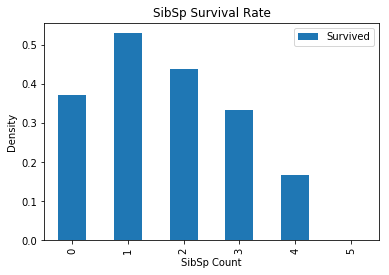

In [556]:
prediction_with_one_factor(SURVIVED, 'SibSp', 'SibSp Survival Rate', 'SibSp Count', DENSITY)

- 图形解读：x轴代表乘客间有兄弟姐妹或配偶关系的数量，y轴代表存活率系数
- 数据解读：关系数量0个的存活率：37.15%，1个的存活率：53%，2个的存活率：44%，3个的存活率：33.33%，4个存活率：16.66%，5个的存活率：0%

### 5、探索乘客间是父母/小孩关系的对存活率的影响

Profile feature "Parch" survival rate
-------------------------------------------
       survived  total      rate
Parch                           
0           186    521  0.357006
1            61    110  0.554545
2            39     68  0.573529
3             3      5  0.600000
4             0      4  0.000000
5             1      5  0.200000
6             0      1  0.000000


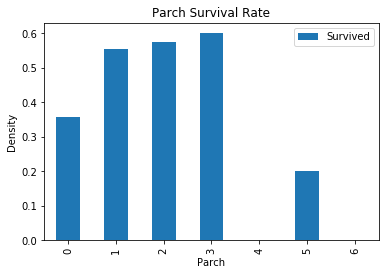

In [557]:
prediction_with_one_factor(SURVIVED, 'Parch', 'Parch Survival Rate', 'Parch', DENSITY)

- 图形解读：x轴代表乘客中父母携带小孩的数量，y轴代表存活率系数
- 数据解读：小孩数量0个的存活率：35.70%，1个的存活率：55.45%，2个的存活率：57.35%，3个的存活率：60%，4个存活率：0%，5个的存活率：20%，6个的存活率：0%

### 6、探索票价对存活率的影响

Profile feature "Fare" survival rate
-------------------------------------------
           survived  total      rate
FareLevel                           
0~40            187    555  0.336937
40-100           66    104  0.634615
100-200          22     30  0.733333
200-300          11     15  0.733333
300~550           3      3  1.000000


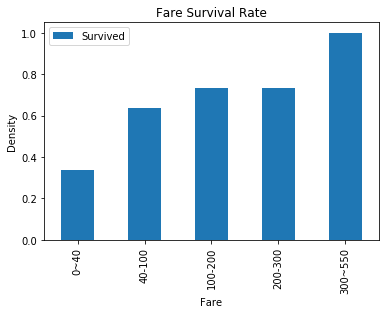

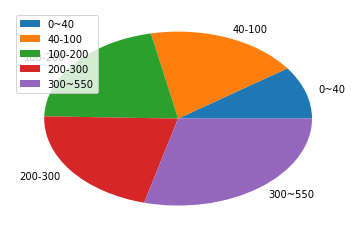

In [558]:
bins = [0, 40, 100, 200, 300, 550]
labels = ['0~40', '40-100', '100-200', '200-300', '300~550']
prediction_with_interval_factor(SURVIVED, 'Fare', 'FareLevel', bins, labels, 'Fare Survival Rate', 'Fare', DENSITY)

- 图形解读：柱状图x轴代表各区间票价，y轴代表存活率系数
- 数据解读：0-40的存活率：33.69%，40-100的存活率：63.46%，100-200个的存活率：73.33%，200-300的存活率：73.33%，300-550存活率：100%

### 7、探索舱室等级与性别的综合因素对存活率的影响

Profile feature "Pclass + Sex" survival rate
-------------------------------------------
               survived  total      rate
Pclass Sex                              
1      female        82     85  0.964706
       male          40    101  0.396040
2      female        68     74  0.918919
       male          15     99  0.151515
3      female        47    102  0.460784
       male          38    253  0.150198


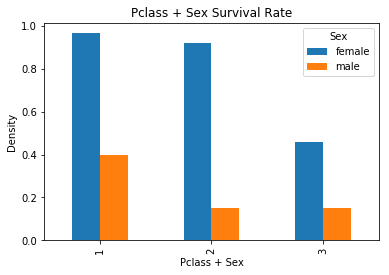

In [559]:
prediction_with_double_factor(SURVIVED, 'Pclass', 'Sex', 'Pclass + Sex Survival Rate', 'Pclass + Sex', DENSITY)

- 图形解读：x轴代表不同等级的舱室中男女存活数据，y轴代表存活率系数
- 数据解读：1级舱室中男女存活率分别为：39.6%、96.47%，2级舱室中男女存活率分别为：15.15%、91.89%，3级舱室中男女存活率分别为：15.01%、46.07%

## Drawing Conclusions Phase ( Make Predictions) 总结与预测

- 泰坦尼克号上有2224名乘客和船员，乘客1300多人，船员800多人，我们对891条乘客的样本清洗后得到了714条特征分析数据，分析数据占了样本数据的87%，占了总乘客数的近60%。从特征数据分析得出，小孩、女士、高等级舱室的存活率较高，如果891名样本数据是随机抽选，根据中心极限定理，该样本的数据足够大，那么我们的分析结果就具有代表性，但如果不是随机选取，由于数据有缺失且不完整，那么我们的分析结果就可能不太靠谱了。
- 另外船上还有800多名船员和工作人员，工作人员在处理逃生时发挥的作用不容小觑，但是我们没有对这部分数据进行分析，因此乘客的生存率结论不能完全准确。
- 很多故事和细节已经永远地沉没在大海中，我们面对的只是冷冰冰的数据。但是数据遮掩不了船上男士们的英勇，正是男士们的担当和牺牲，让船上大部分女士和超过半数的儿童获救了。
- 人类历史上，曾经发生过很多灾难，值得人类自豪的是，危难来临之际，很多人并没有忘记人生价值和尊严。即使面对死亡，他们仍然坚持自己的理想和信念，勇敢向前，捍卫了人性的光辉。

## Communication Phase 交流研究成果

- 舱室等级越高，存活率越高
- 女士的存活率明显高于男士，正常情况下女士的逃生能力低于男士，却获得了高存活率，因此可以推测女士在逃生时得到了优先照顾
- 青少年的存活率较中老年明显高，因此可以推测青少年在逃生时得到了优先照顾
- 1个亲戚的存活率最高，超过2个亲戚的情况存活率不断下降，可能逃生时亲戚越多顾虑越多，需要照顾的人越多，存活率反而不如独自一个人高
- 小孩数量0-3个的存活率较高，多于3个的存活率降低，可以推测带小孩的给予了优先逃生照顾，但是小孩太多也影响了存活率，逃生时的精力分散可能造成了直接影响，但这只是猜测，毕竟样本数据有限
- 票价越高的存活率越高，票价高的应该在高等舱室，这与舱室等级的探索结论相吻合
- 无论在什么等级的舱室，女士都比男士存活率高，舱室等级高的男女存活率优于等级低的舱室，可以推测舱室等于对存活率的影响较大，也可以推测男士很有担当，将逃生希望优先给予了女士